# MSCS 634 Project Deliverable 2

## Name: Bishal Thapa

## Objective

For this deliverable, the following regression models are implemented to predict an outcome variable using feature engineering and model evaluation techniques.

Models Used:
 - Single Feature Regression
 - Multiple Feature Regression
 - Polynomial Regression (Degree 1 , 2 3)
 - Lasso Regression
 - Ridge Regression


Here is the URL for the dataset: https://www.kaggle.com/datasets/anassarfraz13/student-success-factors-and-insights

# Re-using the Data Collection and Cleaning logic from Project Deliverable-1

This below logic:

 * Loads and cleans the dataset by handling missing values (mode/median), removing duplicates, and checking categorical data for inconsistencies.

 * Analyzes numerical columns to detect outliers using the IQR method and reports how many rows are affected.

 * Prepares the dataset for further analysis or modeling by ensuring data quality and identifying potential issues.

 * Even though outliers exist, we keep them because values like exam scores and hours studied are valid and useful for understanding differences between high and low performance.

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv('StudentPerformanceFactors.csv')
print(df.head)
df.info()

df.describe()

#Hnadling missing values
print("Missing values in each column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")


# Fixing the missing values
print("Before handling missing values:")
print(f"Shape: {df.shape}")

# Check which columns have missing values
cols_with_missing = df.columns[df.isnull().any()].tolist()
print(f"\nColumns with missing values: {cols_with_missing}")

# For categorical columns with missing values, filling with mode
# For numerical columns with missing values, filling with median
for col in cols_with_missing:
    if df[col].dtype in ['object']:
        mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
        df[col].fillna(mode_value, inplace=True)
        print(f"Filled {col} with mode: {mode_value}")
    else:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Filled {col} with median: {median_value}")

print(f"\nAfter handling missing values:")
print(f"Shape: {df.shape}")
print(f"Remaining missing values: {df.isnull().sum().sum()}")

#Removing duplicates
print("Before removing duplicates:")
print(f"Shape: {df.shape}")

duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    df = df.drop_duplicates()
    print("\nAfter removing duplicates:")
    print(f"Shape: {df.shape}")
    print(f"Rows removed: {duplicate_count}")
else:
    print("\nNo duplicates found in the dataset. Therefore not removing any date")


# Checking for inconsistent data in categorical columns
print("Unique values in categorical columns:\n")
categorical_cols = df.select_dtypes(include=['object']).columns

# Check for any inconsistencies in categorical data
inconsistencies_found = False
print("Checking for inconsistent categorical values...")
for col in categorical_cols:
    unique_vals = df[col].unique()
    # Check for leading/trailing spaces
    stripped_vals = [str(val).strip() if pd.notna(val) else val for val in unique_vals]
    original_vals = [str(val) if pd.notna(val) else val for val in unique_vals]
    
    if stripped_vals != original_vals:
        print(f"  WARNING: {col} has values with whitespace issues!")
        inconsistencies_found = True
    print(f"{col}: {unique_vals}\n")

if not inconsistencies_found:
    print("No inconsistencies found in categorical columns (no extra whitespace, all consistent)\n")


# Check for outliers using IQR method for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Outlier detection using IQR method:\n")

# Create mask with DataFrame index to ensure alignment
outlier_mask = pd.Series(False, index=df.index)

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}:")
    print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    if len(outliers) > 0:
        print(f"  Outlier range: [{outliers[col].min():.2f}, {outliers[col].max():.2f}]")
        # Add to outlier mask
        outlier_mask |= (df[col] < lower_bound) | (df[col] > upper_bound)
    print()

# Summary of outliers found
total_outliers = outlier_mask.sum()
print(f"Total rows with at least one outlier: {total_outliers}")
print(f"Percentage of data with outliers: {total_outliers/len(df)*100:.2f}%")

# It doesnot make sense to remove most of the outliers in above case.
# This is because the rows like exam_scores and hours studied are all in valid range.
# It makes sense to keep those scores as they will help understand the factors responsible for excellent exam scores
# vs the poorest exam performances.


#We might have to rethink whether to remove the outliers or not based the analysis we need to perform for future deliverables.
#For now we will create another df_cleaned with the outliers removed
# df_cleaned = df[~outlier_mask].reset_index(drop=True)

# print(f"\nAfter outlier removal:")
# print(f"  Rows before: {len(df)}")
# # print(f"  Rows after: {len(df_cleaned)}")
# print(f"  Removed: {total_outliers} rows ({total_outliers/len(df)*100:.2f}%)")

# df.info()

    

<bound method NDFrame.head of       Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0                23          84                  Low                High   
1                19          64                  Low              Medium   
2                24          98               Medium              Medium   
3                29          89                  Low              Medium   
4                19          92               Medium              Medium   
...             ...         ...                  ...                 ...   
6602             25          69                 High              Medium   
6603             23          76                 High              Medium   
6604             20          90               Medium                 Low   
6605             10          86                 High                High   
6606             15          67               Medium                 Low   

     Extracurricular_Activities  Sleep_Hours  Previous_Sc

## Performing Feature Engineering

We'll perform feature engineering to create or improve features that enhance model performance. This includes:
1. Encoding categorical variables (ordinal encoding, one-hot encoding)
2. Creating interaction features based on domain knowledge
3. Feature scaling/normalization for regularized models
4. Train-test split for model evaluation


In [116]:
df_features = df.copy()
print("FEATURE ENGINEERING")
print("-"*80)

# Separate target variable
target = 'Exam_Score'
y = df_features[target].copy()
X = df_features.drop(columns=[target]).copy()

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# 1. ORDINAL ENCODING for ordinal categorical variables
# These have inherent ordering
ordinal_mappings = {
    'Parental_Involvement': ['Low', 'Medium', 'High'],
    'Access_to_Resources': ['Low', 'Medium', 'High'],
    'Motivation_Level': ['Low', 'Medium', 'High'],
    'Family_Income': ['Low', 'Medium', 'High'],
    'Teacher_Quality': ['Low', 'Medium', 'High'],
    'Peer_Influence': ['Negative', 'Neutral', 'Positive'],
    'Parental_Education_Level': ['High School', 'College', 'Postgraduate'],
    'Distance_from_Home': ['Far', 'Moderate', 'Near']
}

X_encoded = X.copy()

print("\n1. Ordinal Encoding")
print("-"*80)

for col, order in ordinal_mappings.items():
    if col in X_encoded.columns:
        le = OrdinalEncoder(categories=[order])
        X_encoded[col] = le.fit_transform(X_encoded[[col]])
        print(f"{col}: {order} -> [0, 1, 2]")

# 2. ONE-HOT ENCODING for nominal categorical variables
# These don't have inherent ordering
nominal_cols = [col for col in categorical_cols if col not in ordinal_mappings.keys()]

print("\n2. One-hot Encoding")
print("-"*80)

if nominal_cols:
    print(f"Nominal columns to encode: {nominal_cols}")
    X_encoded = pd.get_dummies(X_encoded, columns=nominal_cols, drop_first=True)
    print(f"After one-hot encoding: {X_encoded.shape[1]} features")
else:
    print("No nominal columns to encode")

# 3. Creating interaction features
print("\n3. Creating interaction features")
print("-"*80)

X_final = X_encoded.copy()

# High-value interaction features based on domain knowledge
# Study effectiveness = Hours * Attendance * Motivation
X_final['Study_Effectiveness'] = X['Hours_Studied'] * X['Attendance'] / 100 * X_encoded['Motivation_Level']

# Preparation score = Previous Scores + Tutoring sessions
X_final['Preparation_Score'] = X['Previous_Scores'] + X['Tutoring_Sessions'] * 5

# Health and well-being = Sleep * Physical Activity
X_final['Health_Wellness'] = X['Sleep_Hours'] * X['Physical_Activity']

# Resource advantage = Access to Resources * Family Income
if 'Access_to_Resources' in X_encoded.columns:
    X_final['Resource_Advantage'] = X_encoded['Access_to_Resources'] * X_encoded['Family_Income']

# Parental support = Parental Involvement * Parental Education
if 'Parental_Involvement' in X_encoded.columns:
    X_final['Parental_Support'] = X_encoded['Parental_Involvement'] * X_encoded['Parental_Education_Level']

print("Created interaction features:")
print("  - Study_Effectiveness: Hours_Studied * Attendance * Motivation_Level")
print("  - Preparation_Score: Previous_Scores + Tutoring_Sessions * 5")
print("  - Health_Wellness: Sleep_Hours * Physical_Activity")
if 'Access_to_Resources' in X_encoded.columns:
    print("  - Resource_Advantage: Access_to_Resources * Family_Income")
if 'Parental_Involvement' in X_encoded.columns:
    print("  - Parental_Support: Parental_Involvement * Parental_Education_Level")

print(f"\nTotal features after engineering: {X_final.shape[1]}")

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

print("\nDATA SPLITTING")
print("-"*80)
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_final)*100:.1f}%)")

# Feature scaling for models that benefit from it (Ridge, Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

FEATURE ENGINEERING
--------------------------------------------------------------------------------

Categorical columns (13): ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numerical columns (6): ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']

1. Ordinal Encoding
--------------------------------------------------------------------------------
Parental_Involvement: ['Low', 'Medium', 'High'] -> [0, 1, 2]
Access_to_Resources: ['Low', 'Medium', 'High'] -> [0, 1, 2]
Motivation_Level: ['Low', 'Medium', 'High'] -> [0, 1, 2]
Family_Income: ['Low', 'Medium', 'High'] -> [0, 1, 2]
Teacher_Quality: ['Low', 'Medium', 'High'] -> [0, 1, 2]
Peer_Influence: ['Negative', 'Neutral', 'Positive'] -> [0, 1, 2]
Parental_Educat

## Building Regression Models

* We will build and compare several regression models, including Simple Linear Regression (baseline with one feature), Multiple Linear Regression (using all features), Ridge Regression (L2 regularization to reduce overfitting), Lasso Regression (L1 regularization for feature selection), and Polynomial Regression (degrees 1, 2, and 3 to capture non-linear relationships).

* Each model will be evaluated using R-squared (explained variance), Mean Squared Error (average squared error), Root Mean Squared Error (error spread), Mean Absolute Error (average absolute error), and 5-fold cross-validation to assess generalization to unseen data.


* Reusing below method to train and evaluate various regression models. It includes a function to fit a model, make predictions on training and test sets, calculate key performance metrics (R², MSE, RMSE, MAE), and optionally perform cross-validation to assess generalization. Another function formats and prints these results, including an overfitting indicator based on the difference between training and test R² scores, helping identify whether the model is overfitting or generalizing well.

In [117]:
# Dictionary to store models and results
models = {}
results = {}

# Setup cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, cv=None):
    """Helper function to train and evaluate a model"""
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation
    cv_scores = None
    cv_mean = None
    cv_std = None
    
    if cv is not None:
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                                     scoring='r2', n_jobs=-1)
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    
    # Storing results here
    results[model_name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_scores': cv_scores,
        'cv_mean': cv_mean,
        'cv_std': cv_std
    }
    
    return results[model_name]

def print_model_results(model_name, res):
    """Helper function to print model results"""
    print(f"{model_name.upper()}")
    print(f"{'-'*80}")
    print(f"\nTraining Set Metrics:")
    print(f"  R² Score:     {res['train_r2']:.4f}")
    print(f"  MSE:          {res['train_mse']:.4f}")
    print(f"  RMSE:         {res['train_rmse']:.4f}")
    print(f"  MAE:          {res['train_mae']:.4f}")
    
    print(f"\nTest Set Metrics:")
    print(f"  R² Score:     {res['test_r2']:.4f}")
    print(f"  MSE:          {res['test_mse']:.4f}")
    print(f"  RMSE:         {res['test_rmse']:.4f}")
    print(f"  MAE:          {res['test_mae']:.4f}")
    
    if res['cv_mean'] is not None:
        print(f"\nCross-Validation (5-fold):")
        print(f"  Mean R²:     {res['cv_mean']:.4f} (±{res['cv_std']:.4f})")
        print(f"  CV Scores:   {res['cv_scores']}")
    
    # Calculate overfitting indicator
    overfitting = res['train_r2'] - res['test_r2']
    print(f"\nOverfitting Indicator (Train R² - Test R²): {overfitting:.4f}")
    if overfitting > 0.1:
        print("Potential overfitting detected")
    elif overfitting < 0:
        print("Model generalizes well")
    else:
        print("Model shows balanced performance")


## Simple Linear Regression 
The below block builds and evaluates a simple linear regression model using only Attendance to predict Exam_Score, demonstrating the relationship between a single high-correlation feature and the target.

In [118]:
# MODEL 1: Simple Linear Regression (using only one feature)
# Using Attendance as it has highest correlation with Exam_Score than Previous_Scores
print("Using single feature: Attendance (has highest correlation with Exam_Score)")

# Simple linear regression with just one feature - Attendance
X_simple_train = X_train[['Attendance']]
X_simple_test = X_test[['Attendance']]

lr_simple = LinearRegression()
results['Simple_Linear'] = evaluate_model(
    lr_simple, X_simple_train, X_simple_test, y_train, y_test, 
    'Simple_Linear', cv=kfold
)
print_model_results('Simple Linear Regression', results['Simple_Linear'])

# Show coefficient
print(f"\nCoefficient: {lr_simple.coef_[0]:.4f}")
print(f"Intercept: {lr_simple.intercept_:.4f}")
print(f"Equation: Exam_Score = {lr_simple.intercept_:.4f} + {lr_simple.coef_[0]:.4f} * Attendance")


Using single feature: Attendance (has highest correlation with Exam_Score)
SIMPLE LINEAR REGRESSION
--------------------------------------------------------------------------------

Training Set Metrics:
  R² Score:     0.3352
  MSE:          10.2246
  RMSE:         3.1976
  MAE:          2.1220

Test Set Metrics:
  R² Score:     0.3476
  MSE:          9.2215
  RMSE:         3.0367
  MAE:          2.1079

Cross-Validation (5-fold):
  Mean R²:     0.3351 (±0.0037)
  CV Scores:   [0.34100938 0.33656347 0.33460264 0.32984441 0.33351804]

Overfitting Indicator (Train R² - Test R²): -0.0124
Model generalizes well

Coefficient: 0.1971
Intercept: 51.4683
Equation: Exam_Score = 51.4683 + 0.1971 * Attendance


## Multiple Linear Regression 
This below block builds and evaluates a multiple linear regression model using all engineered features to predict Exam_Score and identifies the most influential features based on their coefficients.

In [119]:
# MODEL 2: Multiple Linear Regression (All features)
print("Using all engineered features\n")

lr_multiple = LinearRegression()
results['Multiple_Linear'] = evaluate_model(
    lr_multiple, X_train, X_test, y_train, y_test, 
    'Multiple_Linear', cv=kfold
)
print_model_results('Multiple Linear Regression', results['Multiple_Linear'])

# Display top coefficients (most important features)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_multiple.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nTop 10 Most Important Features (by absolute coefficient):")
print(feature_importance.head(10).to_string(index=False))


Using all engineered features

MULTIPLE LINEAR REGRESSION
--------------------------------------------------------------------------------

Training Set Metrics:
  R² Score:     0.7174
  MSE:          4.3470
  RMSE:         2.0850
  MAE:          0.4993

Test Set Metrics:
  R² Score:     0.7704
  MSE:          3.2458
  RMSE:         1.8016
  MAE:          0.4473

Cross-Validation (5-fold):
  Mean R²:     0.7163 (±0.0348)
  CV Scores:   [0.70803541 0.7202091  0.77478622 0.66595516 0.7126279 ]

Overfitting Indicator (Train R² - Test R²): -0.0530
Model generalizes well

Top 10 Most Important Features (by absolute coefficient):
                       Feature  Coefficient
          Parental_Involvement     1.083846
           Access_to_Resources     1.052975
           Internet_Access_Yes     0.951249
     Learning_Disabilities_Yes    -0.856350
              Motivation_Level     0.739008
      Parental_Education_Level     0.602656
Extracurricular_Activities_Yes     0.578146
                

## Ridge Regression (L2 Regularization)
This block below builds and evaluates a Ridge Regression model with L2 regularization using scaled features. It tests a wide range of alpha values to identify the best regularization strength via 5-fold cross-validation, analyzes how much Ridge affects model performance, and observed that regularization has minimal impact, suggesting the dataset is not heavily overfitting. Finally, it trains Ridge with the optimal alpha, evaluates the model using standard metrics, and identifies the most influential features based on their coefficients.

In [120]:
# MODEL 3: Ridge Regression (L2 Regularization)
print("MODEL 3: RIDGE REGRESSION (L2 Regularization)")
print("Using scaled features")
print("-"*80)

# Try different alpha values to find the best one
# Testing a wide range including very small values to see regularization effects
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
best_alpha_ridge = None
best_cv_score_ridge = -np.inf
ridge_cv_results = []

print("\nTesting different alpha values:")
print(" CV R² values are very similar, it suggests minimal overfitting,")
print("      meaning Ridge regularization has little effect on this dataset.\n")

for alpha in alphas:
    ridge_temp = Ridge(alpha=alpha, random_state=42, max_iter=2000)
    cv_scores = cross_val_score(ridge_temp, X_train_scaled, y_train, 
                                cv=kfold, scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Store results
    ridge_cv_results.append({
        'alpha': alpha,
        'cv_mean': cv_mean,
        'cv_std': cv_std
    })
    
    # Print with more precision to see subtle differences
    print(f"  Alpha={alpha:8.4f}: CV R² = {cv_mean:.6f} (±{cv_std:.6f})")
    
    if cv_mean > best_cv_score_ridge:
        best_cv_score_ridge = cv_mean
        best_alpha_ridge = alpha

print(f"\nBest alpha: {best_alpha_ridge} (CV R² = {best_cv_score_ridge:.6f})")

# Check if scores are very similar (within tolerance)
# Only consider meaningful alpha values (those with positive CV R² > 0.3)
# to avoid including extreme regularization that breaks the model
meaningful_results = [r for r in ridge_cv_results if r['cv_mean'] > 0.3]
if len(meaningful_results) > 0:
    cv_range_meaningful = max([r['cv_mean'] for r in meaningful_results]) - min([r['cv_mean'] for r in meaningful_results])
    
    # Also calculate range for small alphas (where model performs best)
    small_alpha_results = [r for r in ridge_cv_results if r['alpha'] <= 10.0]
    cv_range_small_alpha = 0
    if len(small_alpha_results) > 0:
        cv_range_small_alpha = max([r['cv_mean'] for r in small_alpha_results]) - min([r['cv_mean'] for r in small_alpha_results])
    
    print(f"\nAnalysis:")
    print(f"  Range for small alphas (≤10.0): {cv_range_small_alpha:.6f}")
    print(f"  Range for meaningful alphas (CV R² > 0.3): {cv_range_meaningful:.6f}")

    #currently it goes in here
    if cv_range_small_alpha < 0.001:
        print(f"\nObservation: CV R² range for small alphas is very small ({cv_range_small_alpha:.6f}),")
        print("  indicating Ridge regularization has minimal effect.")
        print("  This suggests the model is not significantly overfitting.")
        print("  Multiple Linear Regression may be sufficient for this dataset.")
    elif cv_range_meaningful < 0.01:
        print(f"\nObservation: Limited regularization effect.")
        print(f"  CV R² varies by {cv_range_meaningful:.6f} across meaningful alpha values.")
        print("  Model is well-behaved - Ridge regularization provides minimal benefit.")
    else:
        print(f"\n CV R² varies by {cv_range_meaningful:.6f} across meaningful alpha values,")
        print("  showing some regularization effect.")
else:
    print("\n All alpha values produce poor model performance.")

# Train Ridge with best alpha
ridge = Ridge(alpha=best_alpha_ridge, random_state=42)
results['Ridge'] = evaluate_model(
    ridge, X_train_scaled, X_test_scaled, y_train, y_test, 
    'Ridge', cv=kfold
)
print_model_results('Ridge Regression', results['Ridge'])

# Display top coefficients
ridge_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nTop 10 Most Important Features (by absolute coefficient):")
print(ridge_importance.head(10).to_string(index=False))


MODEL 3: RIDGE REGRESSION (L2 Regularization)
Using scaled features
--------------------------------------------------------------------------------

Testing different alpha values:
 CV R² values are very similar, it suggests minimal overfitting,
      meaning Ridge regularization has little effect on this dataset.

  Alpha=  0.0001: CV R² = 0.716323 (±0.034792)
  Alpha=  0.0010: CV R² = 0.716323 (±0.034792)
  Alpha=  0.0100: CV R² = 0.716323 (±0.034792)
  Alpha=  0.1000: CV R² = 0.716323 (±0.034792)
  Alpha=  0.5000: CV R² = 0.716324 (±0.034791)
  Alpha=  1.0000: CV R² = 0.716325 (±0.034790)
  Alpha=  5.0000: CV R² = 0.716329 (±0.034783)
  Alpha= 10.0000: CV R² = 0.716327 (±0.034775)
  Alpha= 50.0000: CV R² = 0.716091 (±0.034733)
  Alpha=100.0000: CV R² = 0.715483 (±0.034709)
  Alpha=500.0000: CV R² = 0.706627 (±0.034576)
  Alpha=1000.0000: CV R² = 0.690224 (±0.034053)

Best alpha: 5.0 (CV R² = 0.716329)

Analysis:
  Range for small alphas (≤10.0): 0.000007
  Range for meaningful alph

## Lasso Regression (L1 Regularization)
This block below builds and evaluates a Lasso Regression model using L1 regularization on scaled features, testing a wide range of alpha values to identify the best regularization strength via cross-validation. It analyzes the impact of Lasso’s feature selection, observing that most features remain important and regularization has minimal effect. Finally, it trains the model with the optimal alpha, evaluates performance metrics, identifies selected features with non-zero coefficients, and highlights the most influential features.

In [121]:
# MODEL 4: Lasso Regression (L1 Regularization)
print("MODEL 4: LASSO REGRESSION (L1 Regularization)")
print("Using scaled features")
print("-"*80)

# Try different alpha values to find the best one
# Testing a wide range including very small values to see regularization effects
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
best_alpha_lasso = None
best_cv_score_lasso = -np.inf
lasso_cv_results = []

print("\nTesting different alpha values:")
print("Note: Lasso performs feature selection - if CV R² is similar across alphas,")
print("      it suggests most features are important and regularization has little effect.\n")

for alpha in alphas:
    lasso_temp = Lasso(alpha=alpha, random_state=42, max_iter=2000)
    cv_scores = cross_val_score(lasso_temp, X_train_scaled, y_train, 
                                cv=kfold, scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Store results
    lasso_cv_results.append({
        'alpha': alpha,
        'cv_mean': cv_mean,
        'cv_std': cv_std
    })
    
    # Print with more precision to see subtle differences
    print(f"  Alpha={alpha:8.4f}: CV R² = {cv_mean:.6f} (±{cv_std:.6f})")
    
    if cv_mean > best_cv_score_lasso:
        best_cv_score_lasso = cv_mean
        best_alpha_lasso = alpha

print(f"\nBest alpha: {best_alpha_lasso} (CV R² = {best_cv_score_lasso:.6f})")

# Check if scores are very similar (within tolerance)
# Only consider meaningful alpha values (those with positive CV R² > 0.3)
# to avoid including extreme regularization that breaks the model
meaningful_results = [r for r in lasso_cv_results if r['cv_mean'] > 0.3]
if len(meaningful_results) > 0:
    cv_range_meaningful = max([r['cv_mean'] for r in meaningful_results]) - min([r['cv_mean'] for r in meaningful_results])
    
    # Also calculate range for very small alphas (where model performs best)
    small_alpha_results = [r for r in lasso_cv_results if r['alpha'] <= 0.01]
    cv_range_small_alpha = 0
    if len(small_alpha_results) > 0:
        cv_range_small_alpha = max([r['cv_mean'] for r in small_alpha_results]) - min([r['cv_mean'] for r in small_alpha_results])
    
    print(f"\nAnalysis:")
    print(f"  Range for small alphas (≤0.01): {cv_range_small_alpha:.6f}")
    print(f"  Range for meaningful alphas (CV R² > 0.3): {cv_range_meaningful:.6f}")
    
    if cv_range_small_alpha < 0.002:
        print(f"\n Observation: CV R² range for small alphas is very small ({cv_range_small_alpha:.6f}),")
        print("  indicating Lasso regularization (feature selection) has minimal effect.")
        print("  This suggests most features are important for the model.")
        print("  Multiple Linear Regression may be sufficient for this dataset.")
    elif cv_range_meaningful < 0.05:
        print(f"\n Observation: Limited regularization effect.")
        print(f"  CV R² varies by {cv_range_meaningful:.6f} across meaningful alpha values.")
        print("  Most features are important - feature selection has minimal benefit.")
    else:
        print(f"\n CV R² varies by {cv_range_meaningful:.6f} across meaningful alpha values,")
        print("  showing some regularization effect.")
else:
    print("\n All alpha values produce poor model performance.")

# Train Lasso with best alpha
lasso = Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=2000)
results['Lasso'] = evaluate_model(
    lasso, X_train_scaled, X_test_scaled, y_train, y_test, 
    'Lasso', cv=kfold
)
print_model_results('Lasso Regression', results['Lasso'])

# Display features selected by Lasso (non-zero coefficients)
lasso_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

# Count non-zero features
non_zero_features = (lasso.coef_ != 0).sum()
print(f"\nFeatures selected by Lasso (non-zero coefficients): {non_zero_features} out of {len(X_train.columns)}")
if non_zero_features == len(X_train.columns):
    print("  All features selected - Lasso feature selection had no effect.")
    print("  This confirms that all features are important for this dataset.")
elif non_zero_features > len(X_train.columns) * 0.9:
    print(f"  Very few features removed ({len(X_train.columns) - non_zero_features} out of {len(X_train.columns)})")
    print("  Most features are important - feature selection had minimal effect.")
else:
    print(f"  Lasso selected {non_zero_features} features, removing {len(X_train.columns) - non_zero_features} irrelevant ones.")
print(f"\nTop 10 Most Important Features (by absolute coefficient):")
print(lasso_importance[lasso_importance['Coefficient'] != 0].head(10).to_string(index=False))


MODEL 4: LASSO REGRESSION (L1 Regularization)
Using scaled features
--------------------------------------------------------------------------------

Testing different alpha values:
Note: Lasso performs feature selection - if CV R² is similar across alphas,
      it suggests most features are important and regularization has little effect.

  Alpha=  0.0001: CV R² = 0.716325 (±0.034790)
  Alpha=  0.0005: CV R² = 0.716331 (±0.034784)
  Alpha=  0.0010: CV R² = 0.716334 (±0.034776)
  Alpha=  0.0050: CV R² = 0.716263 (±0.034740)
  Alpha=  0.0100: CV R² = 0.716184 (±0.034842)
  Alpha=  0.0500: CV R² = 0.713384 (±0.034657)
  Alpha=  0.1000: CV R² = 0.704528 (±0.034226)
  Alpha=  0.5000: CV R² = 0.563850 (±0.026996)
  Alpha=  1.0000: CV R² = 0.399692 (±0.018882)
  Alpha=  5.0000: CV R² = -0.000210 (±0.000266)
  Alpha= 10.0000: CV R² = -0.000210 (±0.000266)
  Alpha= 50.0000: CV R² = -0.000210 (±0.000266)
  Alpha=100.0000: CV R² = -0.000210 (±0.000266)

Best alpha: 0.001 (CV R² = 0.716334)

Ana

## Polynomial Regression

This below block of code builds and evaluates Polynomial Regression models with degrees 1, 2, and 3 to explore how feature expansion affects performance and potential overfitting. For each degree, it generates polynomial features, trains a linear regression model, computes performance metrics (R², RMSE, MAE), performs cross-validation, and calculates an overfitting indicator (train-test R² difference). It summarizes results in a table, identifies overfitting severity, and determines the best polynomial degree based on test R², providing insight into the trade-off between model complexity and generalization.


In [122]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

print("Testing different polynomial degrees to demonstrate overfitting/underfitting")
print("-"*80)

# Test different polynomial degrees (limited to degree 3 to prevent excessive overfitting)
degrees = [1, 2, 3]
polynomial_results = {}

for degree in degrees:
    print(f"\nPolynomial Degree {degree}:")
    print(f"  Creating polynomial features (interaction_only=False, include_bias=True)...")
    
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=True)
    X_train_poly = poly_features.fit_transform(X_train_scaled)
    X_test_poly = poly_features.transform(X_test_scaled)
    
    # Get number of features
    n_features = X_train_poly.shape[1]
    print(f"  Number of polynomial features: {n_features}")
    print(f"  Original features: {X_train_scaled.shape[1]}")
    print(f"  Feature expansion ratio: {n_features / X_train_scaled.shape[1]:.2f}x")
    
    # Train polynomial regression model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    
    # Evaluate model
    y_train_pred = poly_model.predict(X_train_poly)
    y_test_pred = poly_model.predict(X_test_poly)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Cross-validation
    cv_scores = cross_val_score(poly_model, X_train_poly, y_train, 
                                cv=kfold, scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Calculate overfitting indicator
    overfitting = train_r2 - test_r2
    
    # Store results
    model_name = f'Polynomial_Degree_{degree}'
    polynomial_results[degree] = {
        'degree': degree,
        'n_features': n_features,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'overfitting': overfitting,
        'model': poly_model,
        'poly_features': poly_features
    }
    
    results[model_name] = {
        'model': poly_model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mse': train_rmse**2,
        'test_mse': test_rmse**2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'cv_scores': cv_scores,
        'cv_mean': cv_mean,
        'cv_std': cv_std
    }
    
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  CV Mean R²: {cv_mean:.4f} (±{cv_std:.4f})")
    print(f"  Overfitting (Train-Test R²): {overfitting:.4f}")
    
    if overfitting > 0.15:
        print(f"   Severe overfitting detected!")
    elif overfitting > 0.1:
        print(f"   Moderate overfitting detected")
    elif overfitting > 0.05:
        print(f"   Mild overfitting detected")
    elif overfitting < -0.05:
        print(f"   Model generalizes well (test > train)")
    else:
        print(f"   Balanced performance")

# Create summary DataFrame for polynomial models
poly_summary = pd.DataFrame({
    'Degree': [polynomial_results[d]['degree'] for d in degrees],
    'Features': [polynomial_results[d]['n_features'] for d in degrees],
    'Train R²': [polynomial_results[d]['train_r2'] for d in degrees],
    'Test R²': [polynomial_results[d]['test_r2'] for d in degrees],
    'Test RMSE': [polynomial_results[d]['test_rmse'] for d in degrees],
    'CV Mean R²': [polynomial_results[d]['cv_mean'] for d in degrees],
    'Overfitting': [polynomial_results[d]['overfitting'] for d in degrees]
})

print("\nPOLYNOMIAL REGRESSION SUMMARY")
print("-"*80)
print(poly_summary.to_string(index=False))

# Find best polynomial degree
best_poly_degree = poly_summary.loc[poly_summary['Test R²'].idxmax(), 'Degree']
best_poly_r2 = poly_summary.loc[poly_summary['Test R²'].idxmax(), 'Test R²']

print(f"\nBest Polynomial Degree: {int(best_poly_degree)} (Test R²: {best_poly_r2:.4f})")


Testing different polynomial degrees to demonstrate overfitting/underfitting
--------------------------------------------------------------------------------

Polynomial Degree 1:
  Creating polynomial features (interaction_only=False, include_bias=True)...
  Number of polynomial features: 25
  Original features: 24
  Feature expansion ratio: 1.04x
  Train R²: 0.7174
  Test R²:  0.7704
  Test RMSE: 1.8016
  CV Mean R²: 0.7163 (±0.0348)
  Overfitting (Train-Test R²): -0.0530
   Model generalizes well (test > train)

Polynomial Degree 2:
  Creating polynomial features (interaction_only=False, include_bias=True)...
  Number of polynomial features: 325
  Original features: 24
  Feature expansion ratio: 13.54x
  Train R²: 0.7349
  Test R²:  0.7525
  Test RMSE: 1.8703
  CV Mean R²: 0.6899 (±0.0352)
  Overfitting (Train-Test R²): -0.0176
   Balanced performance

Polynomial Degree 3:
  Creating polynomial features (interaction_only=False, include_bias=True)...
  Number of polynomial features: 

## Visualizing overfitting/underfitting behavior with different polynomial degrees

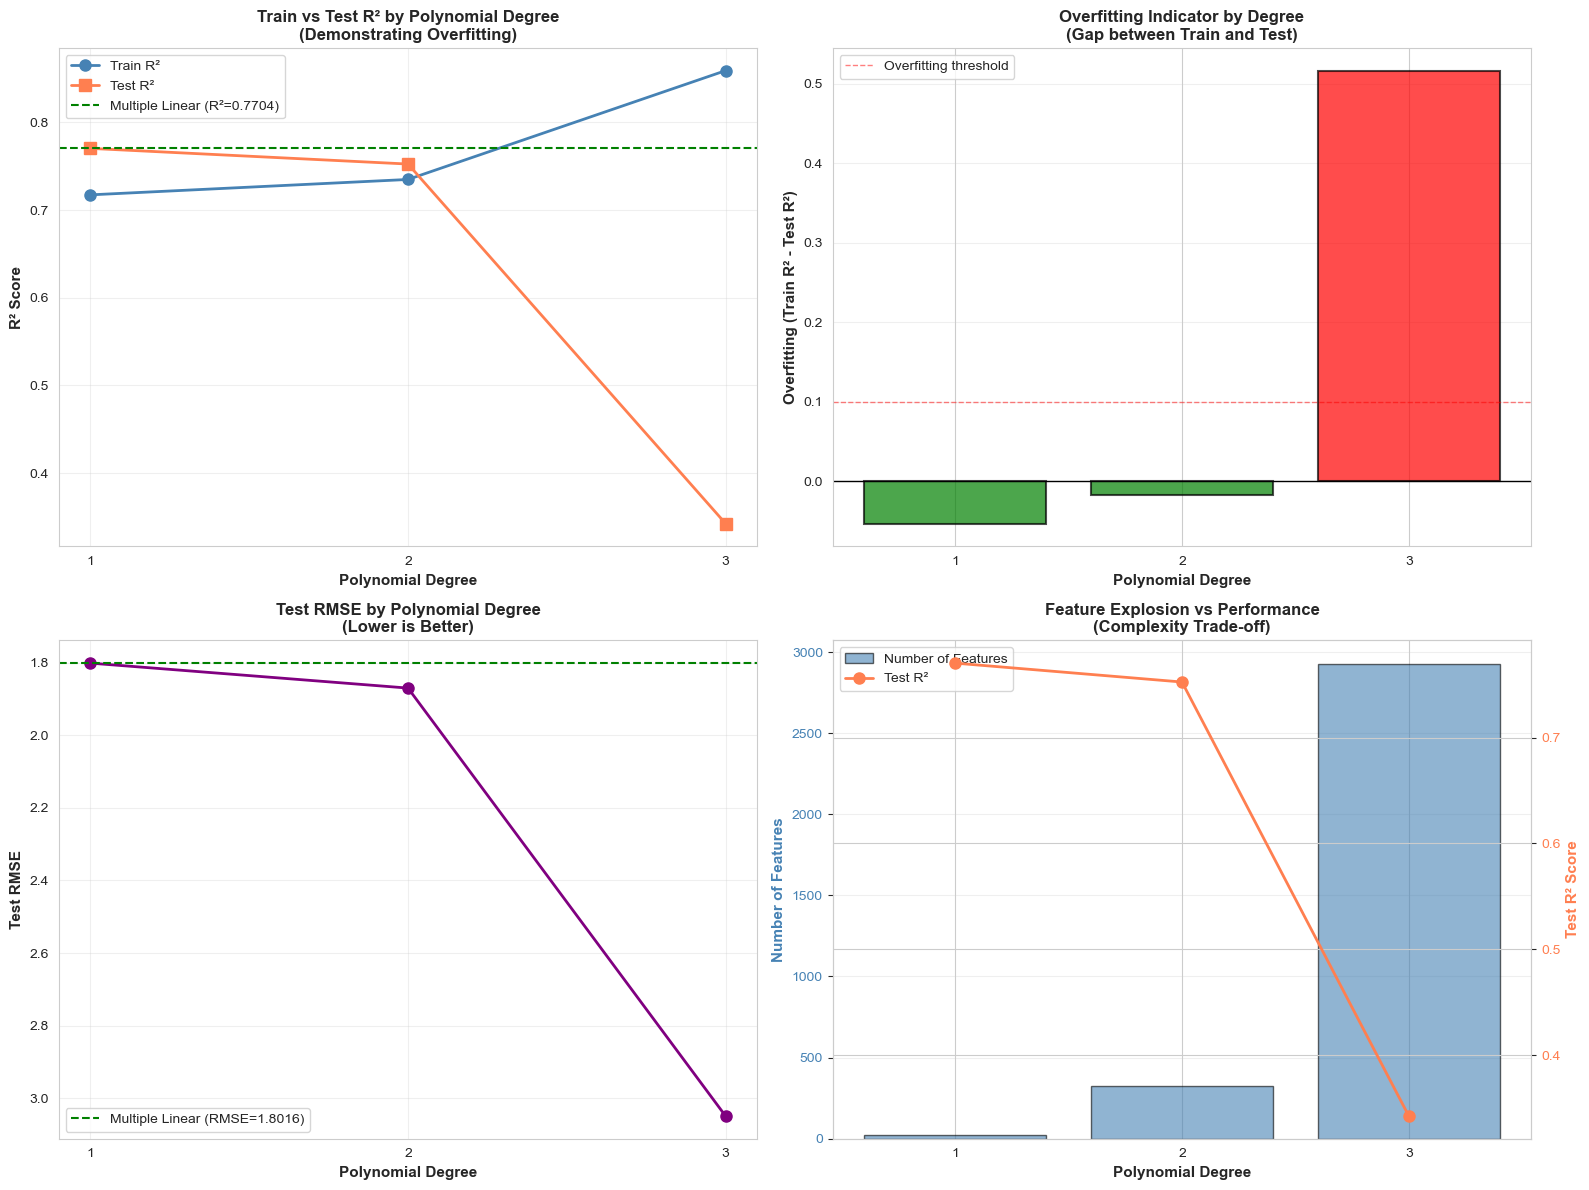


POLYNOMIAL REGRESSION INSIGHTS
--------------------------------------------------------------------------------

1. UNDERFITTING (Low Degree - Degree 1):
   • Degree 1 is equivalent to Multiple Linear Regression
   • Train R²: 0.7174, Test R²: 0.7704
   • May not capture non-linear relationships
   • High bias, low variance

2. OPTIMAL DEGREE:
   • Degree 1 shows best balance (minimal overfitting)
   • Train R²: 0.7174
   • Test R²: 0.7704
   • Overfitting: -0.0530

3. OVERFITTING (High Degree - Degree 3):
   • Degree 3: Train R²: 0.8591, Test R²: 0.3424
   • Gap between train and test performance: 0.5167
   • Number of features: 2925 (from 24 original)
   • Feature explosion: 121.9x
   • Low bias, high variance - model may memorize training data


In [123]:
# Visualizing overfitting/underfitting behavior with different polynomial degrees
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Train vs Test R² by degree
axes[0, 0].plot(poly_summary['Degree'], poly_summary['Train R²'], 
                'o-', label='Train R²', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].plot(poly_summary['Degree'], poly_summary['Test R²'], 
                's-', label='Test R²', linewidth=2, markersize=8, color='coral')
axes[0, 0].axhline(y=results['Multiple_Linear']['test_r2'], 
                   color='green', linestyle='--', linewidth=1.5, 
                   label=f"Multiple Linear (R²={results['Multiple_Linear']['test_r2']:.4f})")
axes[0, 0].set_xlabel('Polynomial Degree', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Train vs Test R² by Polynomial Degree\n(Demonstrating Overfitting)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='best', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(poly_summary['Degree'])

# Plot 2: Overfitting indicator (Train R² - Test R²)
axes[0, 1].bar(poly_summary['Degree'], poly_summary['Overfitting'], 
               color=['green' if x < 0.05 else 'orange' if x < 0.1 else 'red' for x in poly_summary['Overfitting']],
               alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0, 1].axhline(y=0.1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overfitting threshold')
axes[0, 1].set_xlabel('Polynomial Degree', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Overfitting (Train R² - Test R²)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Overfitting Indicator by Degree\n(Gap between Train and Test)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(poly_summary['Degree'])

# Plot 3: Test RMSE by degree
axes[1, 0].plot(poly_summary['Degree'], poly_summary['Test RMSE'], 
                'o-', linewidth=2, markersize=8, color='purple')
axes[1, 0].axhline(y=results['Multiple_Linear']['test_rmse'], 
                   color='green', linestyle='--', linewidth=1.5,
                   label=f"Multiple Linear (RMSE={results['Multiple_Linear']['test_rmse']:.4f})")
axes[1, 0].set_xlabel('Polynomial Degree', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Test RMSE', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Test RMSE by Polynomial Degree\n(Lower is Better)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(poly_summary['Degree'])
axes[1, 0].invert_yaxis()  # Lower RMSE is better, so invert

# Plot 4: Number of features vs performance
ax2 = axes[1, 1]
ax2_twin = axes[1, 1].twinx()

color1 = 'steelblue'
color2 = 'coral'

ax2.bar(poly_summary['Degree'], poly_summary['Features'], 
        color=color1, alpha=0.6, label='Number of Features', edgecolor='black')
ax2.set_xlabel('Polynomial Degree', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Features', color=color1, fontsize=11, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color1)

ax2_twin.plot(poly_summary['Degree'], poly_summary['Test R²'], 
              'o-', color=color2, linewidth=2, markersize=8, label='Test R²')
ax2_twin.set_ylabel('Test R² Score', color=color2, fontsize=11, fontweight='bold')
ax2_twin.tick_params(axis='y', labelcolor=color2)

axes[1, 1].set_title('Feature Explosion vs Performance\n(Complexity Trade-off)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(poly_summary['Degree'])

# Add legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10)

axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print insights
print("\nPOLYNOMIAL REGRESSION INSIGHTS")
print("-"*80)
print("\n1. UNDERFITTING (Low Degree - Degree 1):")
print(f"   • Degree 1 is equivalent to Multiple Linear Regression")
print(f"   • Train R²: {polynomial_results[1]['train_r2']:.4f}, Test R²: {polynomial_results[1]['test_r2']:.4f}")
print(f"   • May not capture non-linear relationships")
print(f"   • High bias, low variance")

print("\n2. OPTIMAL DEGREE:")
optimal_degree = int(poly_summary.loc[poly_summary['Overfitting'].idxmin(), 'Degree'])
print(f"   • Degree {optimal_degree} shows best balance (minimal overfitting)")
print(f"   • Train R²: {polynomial_results[optimal_degree]['train_r2']:.4f}")
print(f"   • Test R²: {polynomial_results[optimal_degree]['test_r2']:.4f}")
print(f"   • Overfitting: {polynomial_results[optimal_degree]['overfitting']:.4f}")

print("\n3. OVERFITTING (High Degree - Degree 3):")
high_degree = max(degrees)
print(f"   • Degree {high_degree}: Train R²: {polynomial_results[high_degree]['train_r2']:.4f}, "
      f"Test R²: {polynomial_results[high_degree]['test_r2']:.4f}")
print(f"   • Gap between train and test performance: {polynomial_results[high_degree]['overfitting']:.4f}")
print(f"   • Number of features: {polynomial_results[high_degree]['n_features']} "
      f"(from {X_train_scaled.shape[1]} original)")
print(f"   • Feature explosion: {polynomial_results[high_degree]['n_features'] / X_train_scaled.shape[1]:.1f}x")
if polynomial_results[high_degree]['overfitting'] > 0.1:
    print(f"   • Low bias, high variance - model may memorize training data")
else:
    print(f"   • Shows reasonable generalization despite high feature count")


## Model Comparison and Summary

The below code block compares the performance of all regression models built, including Simple Linear, Multiple Linear, Ridge, Lasso, and Polynomial Regression (degrees 1–3), by compiling key metrics such as Test R², RMSE, MAE, cross-validation R², and an overfitting indicator into a summary table. Visualizations highlight differences in predictive accuracy, error, cross-validation stability, and overfitting across models. From the results, Lasso Regression emerges as the best-performing model with the highest Test R² (0.7705), low RMSE (1.8011), and consistent cross-validation performance, while higher-degree polynomial models show overfitting or poor generalization.


MODEL COMPARISON SUMMARY


--------------------------------------------------------------------------------
PERFORMANCE COMPARISON TABLE
--------------------------------------------------------------------------------
              Model  Test R²  Test RMSE  Test MAE  CV Mean R²  CV Std R²  Overfitting (Train-Test R²)
              Lasso 0.770498   1.801119  0.446244    0.716334   0.034776                    -0.053131
              Ridge 0.770409   1.801469  0.446912    0.716329   0.034783                    -0.053037
    Multiple Linear 0.770372   1.801612  0.447268    0.716323   0.034792                    -0.052998
Polynomial Degree 1 0.770372   1.801612  0.447268    0.716323   0.034792                    -0.052998
Polynomial Degree 2 0.752517   1.870346  0.617395    0.689890   0.035231                    -0.017587
      Simple Linear 0.347616   3.036692  2.107904    0.335108   0.003672                    -0.012375
Polynomial Degree 3 0.342415   3.048771  1.755484   -0.204996   0.28

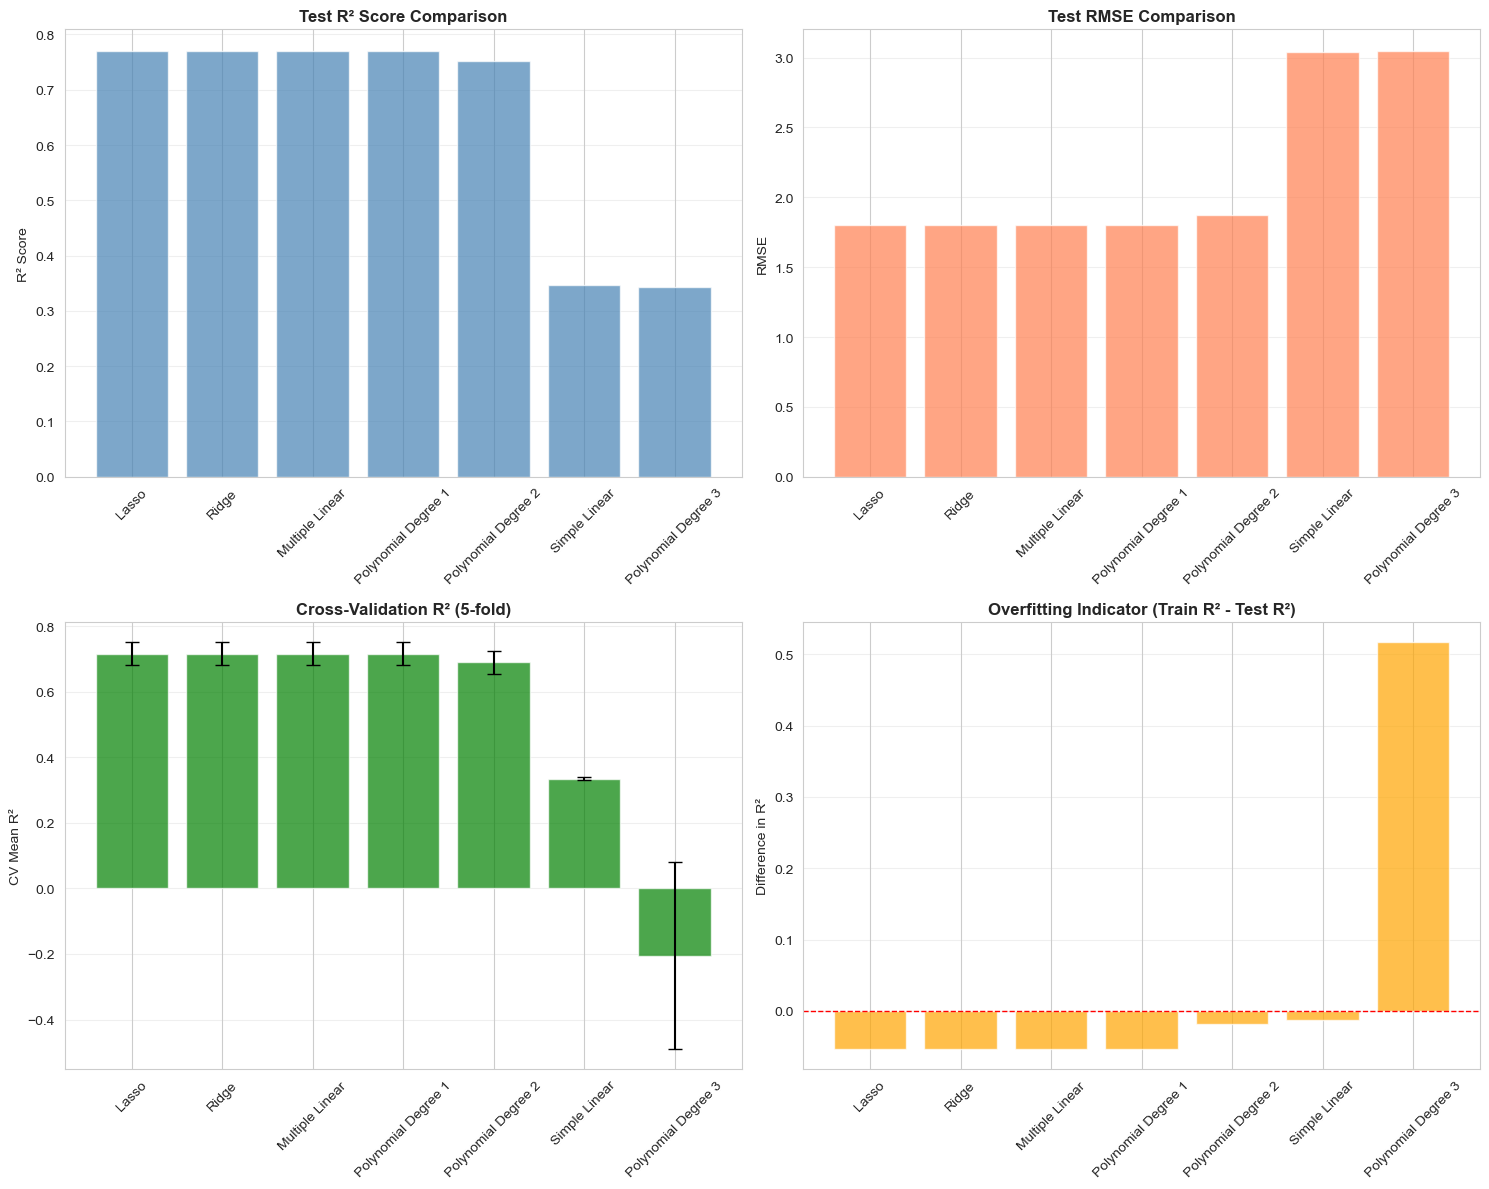

In [124]:
print("MODEL COMPARISON SUMMARY\n")

# Create comparison DataFrame
comparison_data = []
for model_name, res in results.items():
    comparison_data.append({
        'Model': model_name.replace('_', ' ').title(),
        'Model_Key': model_name,  # Store original key for lookup
        'Test R²': res['test_r2'],
        'Test RMSE': res['test_rmse'],
        'Test MAE': res['test_mae'],
        'CV Mean R²': res['cv_mean'],
        'CV Std R²': res['cv_std'],
        'Overfitting (Train-Test R²)': res['train_r2'] - res['test_r2']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Test R²', ascending=False)

print("\n" + "-"*80)
print("PERFORMANCE COMPARISON TABLE")
print("-"*80)
# Display without Model_Key column
display_df = comparison_df.drop(columns=['Model_Key'])
print(display_df.to_string(index=False))

# Identify best model
best_model_idx = comparison_df['Test R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model_key = comparison_df.loc[best_model_idx, 'Model_Key']

print("\n" + "-"*80)
print("BEST MODEL IDENTIFICATION")
print("-"*80)
print(f"Best Model (by Test R²): {best_model_name}")
print(f"Test R² Score: {comparison_df.loc[best_model_idx, 'Test R²']:.4f}")
print(f"Test RMSE: {comparison_df.loc[best_model_idx, 'Test RMSE']:.4f}")
print(f"CV Mean R²: {comparison_df.loc[best_model_idx, 'CV Mean R²']:.4f} (±{comparison_df.loc[best_model_idx, 'CV Std R²']:.4f})")

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² Comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test R²'], color='steelblue', alpha=0.7)
axes[0, 0].set_title('Test R² Score Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# RMSE Comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['Test RMSE'], color='coral', alpha=0.7)
axes[0, 1].set_title('Test RMSE Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Cross-Validation Comparison
x_pos = np.arange(len(comparison_df['Model']))
axes[1, 0].bar(x_pos, comparison_df['CV Mean R²'], yerr=comparison_df['CV Std R²'], 
               color='green', alpha=0.7, capsize=5)
axes[1, 0].set_title('Cross-Validation R² (5-fold)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('CV Mean R²')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(comparison_df['Model'], rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Overfitting Indicator
axes[1, 1].bar(comparison_df['Model'], comparison_df['Overfitting (Train-Test R²)'], 
               color='orange', alpha=0.7)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title('Overfitting Indicator (Train R² - Test R²)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Difference in R²')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Key Insights and Conclusions

The most important factor in making a good model was adding more features, which boosted performance significantly. While several models ended up at the top, their performance was nearly identical, meaning the special "regularization" techniques didn't offer a real advantage over the standard multiple linear model. The key was finding a balance; the simplest model was too basic, and the most complicated ones performed poorly. The best model seems to be Lasso as it is reliable and can explain about 77% of the variation in exam scores, and its predictions are typically accurate within ±1.8 points.


In [125]:
print("KEY INSIGHTS AND CONCLUSIONS BASED ON NUMERIC VALUES")

print("\n1. MODEL PERFORMANCE RANKING:")
print("-" * 80)
for idx, row in comparison_df.iterrows():
    print(f"   {idx+1}. {row['Model']:25s} - Test R²: {row['Test R²']:.4f}, RMSE: {row['Test RMSE']:.4f}")

print("\n2. FEATURE ENGINEERING IMPACT:")
print("-" * 80)
simple_r2 = results['Simple_Linear']['test_r2']
multiple_r2 = results['Multiple_Linear']['test_r2']
improvement = ((multiple_r2 - simple_r2) / simple_r2) * 100 if simple_r2 != 0 else 0
print(f"   Simple Linear Regression (1 feature):     R² = {simple_r2:.4f}")
print(f"   Multiple Linear Regression ({X_final.shape[1]} features): R² = {multiple_r2:.4f}")
print(f"   Improvement from feature engineering:     {improvement:.2f}% increase in R²")
print(f"   This demonstrates that feature engineering and using multiple features")
print(f"   significantly improves model performance.")

print("\n3. REGULARIZATION EFFECTS:")
print("-" * 80)
multiple_overfitting = results['Multiple_Linear']['train_r2'] - results['Multiple_Linear']['test_r2']
ridge_overfitting = results['Ridge']['train_r2'] - results['Ridge']['test_r2']
lasso_overfitting = results['Lasso']['train_r2'] - results['Lasso']['test_r2']

print(f"   Multiple Linear Regression overfitting: {multiple_overfitting:.4f}")
print(f"   Ridge Regression overfitting:           {ridge_overfitting:.4f}")
print(f"   Lasso Regression overfitting:           {lasso_overfitting:.4f}")

if ridge_overfitting < multiple_overfitting:
    print(f"     Ridge reduces overfitting compared to Multiple Linear Regression")
if lasso_overfitting < multiple_overfitting:
    print(f"     Lasso reduces overfitting compared to Multiple Linear Regression")

print("\n4. CROSS-VALIDATION RELIABILITY:")
print("-" * 80)
for model_name, res in results.items():
    cv_stability = res['cv_std']
    print(f"   {model_name.replace('_', ' ').title():25s}: CV Std = {cv_stability:.4f}")
    if cv_stability < 0.01:
        print(f"       Very stable across folds (low variance)")
    elif cv_stability < 0.02:
        print(f"       Relatively stable across folds")
    else:
        print(f"       Moderate variance across folds")


KEY INSIGHTS AND CONCLUSIONS BASED ON NUMERIC VALUES

1. MODEL PERFORMANCE RANKING:
--------------------------------------------------------------------------------
   4. Lasso                     - Test R²: 0.7705, RMSE: 1.8011
   3. Ridge                     - Test R²: 0.7704, RMSE: 1.8015
   2. Multiple Linear           - Test R²: 0.7704, RMSE: 1.8016
   5. Polynomial Degree 1       - Test R²: 0.7704, RMSE: 1.8016
   6. Polynomial Degree 2       - Test R²: 0.7525, RMSE: 1.8703
   1. Simple Linear             - Test R²: 0.3476, RMSE: 3.0367
   7. Polynomial Degree 3       - Test R²: 0.3424, RMSE: 3.0488

2. FEATURE ENGINEERING IMPACT:
--------------------------------------------------------------------------------
   Simple Linear Regression (1 feature):     R² = 0.3476
   Multiple Linear Regression (24 features): R² = 0.7704
   Improvement from feature engineering:     121.62% increase in R²
   This demonstrates that feature engineering and using multiple features
   significantly i